# Integrate and fire model.

In [2]:
# Our numerical workhorses
import numpy as np
import scipy as sp
import pandas as pd

# Useful packages
import itertools

# Import matplotlib stuff for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Seaborn, useful for graphics
import seaborn as sns

# favorite Seaborn settings for notebooks
rc={'lines.linewidth': 2, 
    'axes.facecolor' : 'F4F3F6',
    'axes.edgecolor' : '000000',
    'axes.linewidth' : 1.2,
    'grid.color' : 'a6a6a6',
    'lines.linewidth': 2,
    'axes.labelsize': 18,
    'axes.titlesize': 20,
    'xtick.major' : 13,
    'xtick.labelsize': 'large',
    'ytick.labelsize': 13,
    'font.family': 'Lucida Sans Unicode',
    'grid.linestyle': ':',
    'grid.linewidth': 1.5,
    'mathtext.fontset': 'stixsans',
    'mathtext.sf': 'sans',
    'legend.frameon': True,
    'legend.fontsize': 13}

plt.rc('text.latex', preamble=r'\usepackage{sfmath}')
plt.rc('mathtext', fontset='stixsans', sf='sans')
sns.set_style('darkgrid', rc=rc)
sns.set_palette("colorblind", color_codes=True)
sns.set_context('notebook', rc=rc)

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables great graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

figdir = '../output/integrate_and_fire/'

# Defining the integrate and fire model.

For this simulation we will use the classic integrate-and-fire model in which a neuron's voltage $v(t)$ is affected by the input of other neuron synapses, an external signal and noise.

For a single neuron $i$ we have that the voltage changes over time as
$$
v_i(t + \Delta t) = v_i(t) + (V_o - v_i(t))\Delta t 
+ \sum_{j \neq i} J_{ij} \mathbb{I}(t) \Delta t
+ s_i v_s(t)
+ \xi(t) \Delta t,
$$
where $V_o$ is the basal membrane potential, $J_{ij}$ is the coupling term between neuron $i$ and neuron $j$, $\mathbb{I}(t)$ is the indicator random variable that defines if neuron $j$ fired at time $t$, $v_s(t)$ is an extenral output signal that affects neuron $i$ with strength $s_i$, and $\xi(t)$ is a noise with characteristics
$$
\xi(t) \sim \mathcal{N}(0, \sigma_\xi)
$$
and
$$
\left\langle \xi(t)\xi(t') \right\rangle = \xi(t)\delta(t - t').
$$

We can write the dynamics for all neurons as
$$
\vec{v}(t + \Delta t) = \vec{v}(t) + (\vec{V}_o - \vec{v}(t))\Delta t 
+ \mathbf{J} \cdot \vec{\mathbb{I}}(t) \Delta t
+ v_s(t) \vec{s}(t)
+ \vec{\xi}(t) \Delta t.
$$

Let's define a simple function that performs this naive Euler integration.

In [3]:
def int_and_fire(v_init, time_steps, delta_t, refractory_time,
                 V_rest, V_thresh, 
                 J_mat, s_array, kwargs, sigma_noise=0, signal_fun=None):
    '''
    Euler integration of the time dynamics of neurons under the 
    integrate-and-fire model.
    
    Parameters
    ----------
    v_init : array-like.
        Initial value of the neurons
    time_steps : int.
        Number of time steps on which to perform the integration
    delta_t : float.
        Size of the time step
    refractory_time : int.
        Number of time steps that the cell should remain off after firing.
    V_rest : float.
        Resting potential of a neuron.
    V_thresh : float.
        Threshold potential for when a neuron fires.
    J_mat : 2D-array
        Coupling between neurons.
    s_array : array-like.
        Neuron response to the signal.
    sigma_noise : float.
        Standard deviation of the noise in the neurons.
        NOTE: if zero it is assumed that the noise is negligible
    signal_fun : function. Default NONE
        Function to evaluate the external signal as a function of time.
    kwargs : dict.
        Argument to be passed to the signal_fun function.
        
    Returns
    -------
    v_array : 2D-array.
        Time dynamics of each of the neurons
    fire_array  : 2D-array.
        Binary array that indicates when each of the neurons fired.
    '''
    # Define number of neurons
    n_neurons = len(v_init)
    
    # Define time array
    time_array = np.arange(time_steps) * delta_t
    
    # Initialize matrix to save time dynamics
    v_dynamics = np.zeros([n_neurons, len(time_array) + 1])
    
    # set initial condition
    v_dynamics[:, 0] = v_init
    
    # Initialize the array to save the firing events for each neuron
    fire_array = np.zeros_like(v_dynamics)
    
    # set initial condition
    fire_array[:, 0] = [int(x) for x in v_init >= V_thresh]
    
    # Initialize matrix to save refractory times
    refract_mat = np.zeros([n_neurons, len(time_array) + 1])
    
    # Save initial positions in which a refractory time happens
    fire_idx = fire_array[:, 0] == 1
    refract_mat[fire_idx, 0:refractory_time] = 1
    
    # Compute the signal for each of the time points
    if signal_fun != None:
        signal_array = signal_fun(time_array, **kwargs)
    else:
        signal_array = [0] * time_steps
    
    # Loop through each of the time points
    for i, t in enumerate(time_array):
        # Check if the model has noise
        if sigma_noise > 0:
            noise = np.random.normal(0, sigma_noise, n_neurons)
        else:
            noise = [0] * n_neurons
        
        # Update potential
        v_dynamics[:, i+1] = v_dynamics[:, i]\
                            + (V_rest - v_dynamics[:, i]) * delta_t\
                            + J_mat.dot(fire_array[:, i]) * delta_t\
                            + signal_array[i] * s_array * delta_t\
                            + noise
        
        # Check for neurons that fired 
        fire_idx = v_dynamics[:, i+1] >= V_thresh
        fire_array[:, i+1] = [int(x) for x in fire_idx]
        
        # Update refractory matrix to save times where neurons should remain
        # silent
        refract_mat[fire_idx, (i+1):(i+1+refractory_time)] = 1
        
        # Reset the voltage for neurons that fired
        v_dynamics[fire_idx, i+1] = V_rest
        
        # Reset the voltage of neurons in a refractory time
        refract_idx = refract_mat[:, i] == 1
        v_dynamics[refract_idx, i+1] = V_rest
    
    return v_dynamics, fire_array, refract_mat

## Building inputs for the function.

In order to test the function let's build a simple random example for the coupling matrix $\mathbf{J}$, the signal function and the other entries necessary for the `int_and_fire` function.

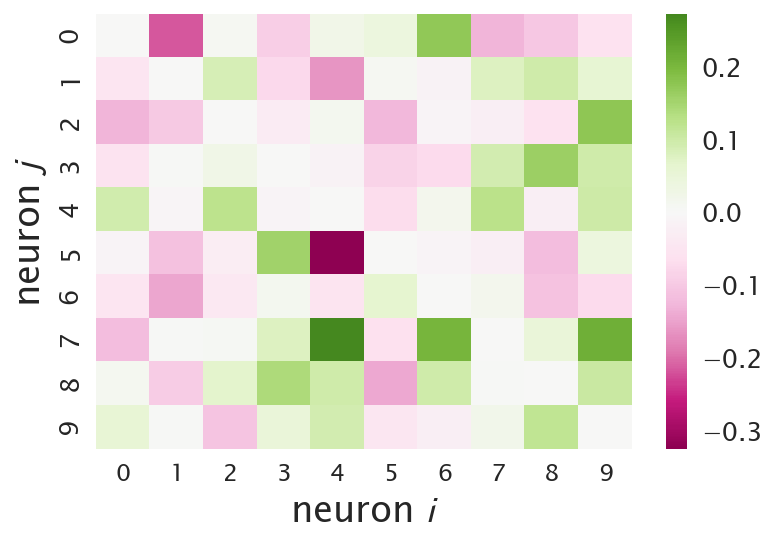

In [4]:
# Define number of neurons
n_neurons = 10

# Define neurons initial condition
v_init = np.zeros(n_neurons)

# Define resting and threshold voltages
V_rest = 0
V_thresh = 1

# Define time variables
time_steps = 10000
delta_t = 0.01
refractory_time = 5

# Define noise standard deviation
sigma_noise = 0.25

# Build random coupling matrix
J_mat = np.random.normal(0, 0.1, [n_neurons, n_neurons])

# Set the self-couplings to zero
J_mat[np.diag_indices(n_neurons)] = 0

# Show coupling matrix
sns.heatmap(J_mat, center=0, cmap='PiYG')
plt.xlabel('neuron $i$')
plt.ylabel('neuron $j$')

# Save fig
plt.tight_layout()
plt.savefig(figdir + 'random_coupling.pdf', bbox_inches=True)

Let's now define a simple step-function signal and an array of how each neuron interacts with the signal.

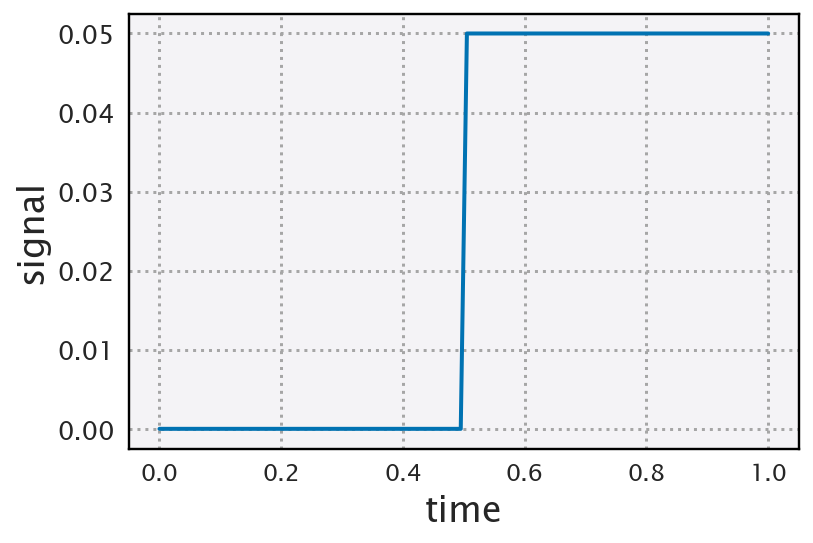

In [284]:
def step_fun(t, ts=0.5, sign=0.05):
    '''
    Step function signal.
    '''
    # Define array to save signal
    signal = np.zeros_like(t)
    
    # Update signal for time
    signal[t > ts] = sign
    
    return signal

# Define array of interactions with signal where only one neuron receives the
# signal
s_array = np.zeros(n_neurons)
s_array[np.random.randint(n_neurons)] = 1 

# Define time
time = np.linspace(0, 1, 100)
plt.plot(time, step_fun(time))
plt.xlabel('time')
_ = plt.ylabel('signal')

Having everything together let's integrate the dynamics.

In [286]:
v_dynamics, fire_array, r = int_and_fire(v_init=v_init, time_steps=time_steps, 
                                      delta_t=delta_t, 
                                      refractory_time=refractory_time,
                                      V_rest=V_rest, V_thresh=V_thresh,  
                                      J_mat=J_mat, s_array=s_array, 
                                      kwargs={'ts' : 5, 'sign':10},
                                      sigma_noise=sigma_noise,
                                      signal_fun=step_fun)

Let's plot the spiking trains.

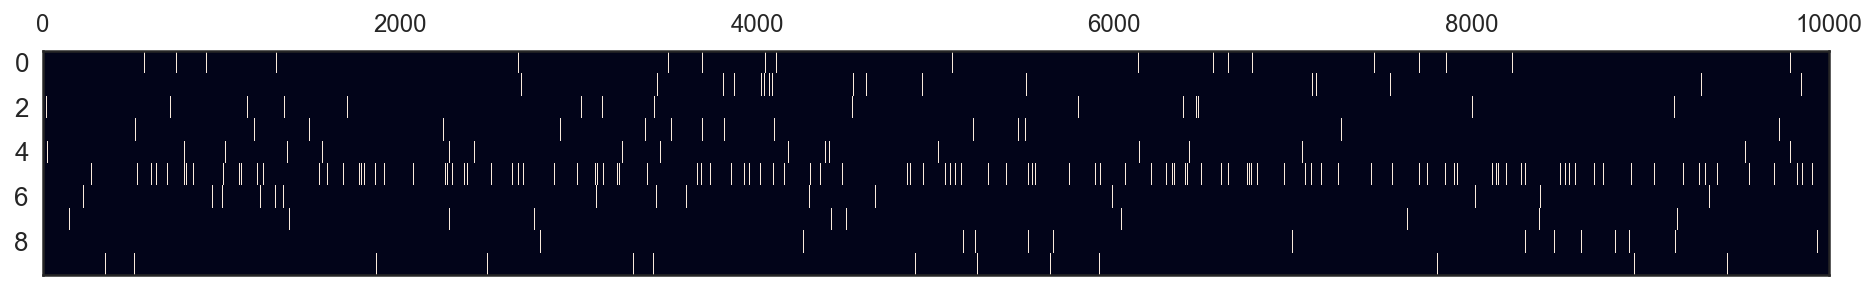

In [287]:
with sns.axes_style('white'):
    plt.matshow(fire_array, aspect='auto')

### Bulding a block coupling matrix $\mathbf{J}$

Just as we saw in the worm data we will now try to build a square block matrix in which two modules are correlated within the block and anti-correlated between blocks.

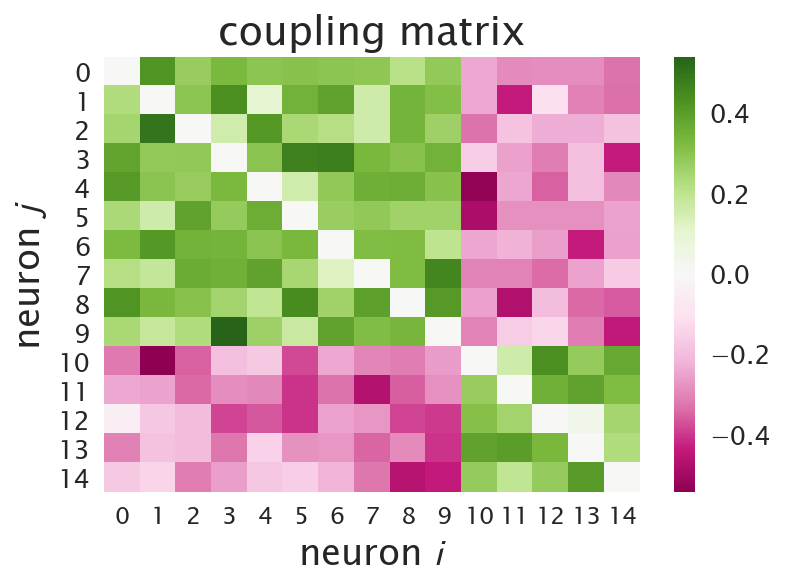

In [307]:
# Define number of cells per block
block_sizes = [10, 5]

# Build the 4 blocks in the matrix with different means for each random 
# coupling parameters
means = np.array([[1, -1],
                  [-1, 1]])

means = means * 0.3
sigma = 1 / 10
# Initialize list to save blocks
blocks = []
# Loop through block sizes
for i, b1 in enumerate(block_sizes):
    for j, b2 in enumerate(block_sizes):
        blocks.append(np.random.normal(means[i, j], sigma, [b1, b2]))

J1 = np.hstack([blocks[0], blocks[1]])
J2 =  np.hstack([blocks[2], blocks[3]])
J_mat = np.vstack([J1, J2])
# Set the self-couplings to zero
J_mat[np.diag_indices(n_neurons)] = 0

# Show coupling matrix
sns.heatmap(J_mat, center=0, cmap='PiYG')
plt.xlabel('neuron $i$')
plt.ylabel('neuron $j$')
_ = plt.title('coupling matrix')

Having build the block matrix let's run the dynamics.

In [311]:
# Define number of neurons
n_neurons = np.sum(block_sizes)
# Define neurons initial condition
v_init = np.zeros(n_neurons)

# Define resting and threshold voltages
V_rest = 0
V_thresh = 1

# Define time variables
time_steps = 500
delta_t = 0.01
refractory_time = 0

# Define noise standard deviation
sigma_noise = 1

# Define array of interactions with signal where only one neuron receives the
# signal
s_array = np.zeros(n_neurons)
# Transform an intra block neuron to be the communicator between blocks
s_array[0] = 2
s_array[-1] = 2

In [316]:
v_dynamics, fire_array, r = int_and_fire(v_init=v_init, time_steps=time_steps, 
                                      delta_t=delta_t,
                                      refractory_time=refractory_time,
                                      V_rest=V_rest, V_thresh=V_thresh / 10,  
                                      J_mat=J_mat, s_array=s_array, 
                                      kwargs={'ts' : 5, 'sign':10},
                                      sigma_noise=sigma_noise,
                                      signal_fun=step_fun)

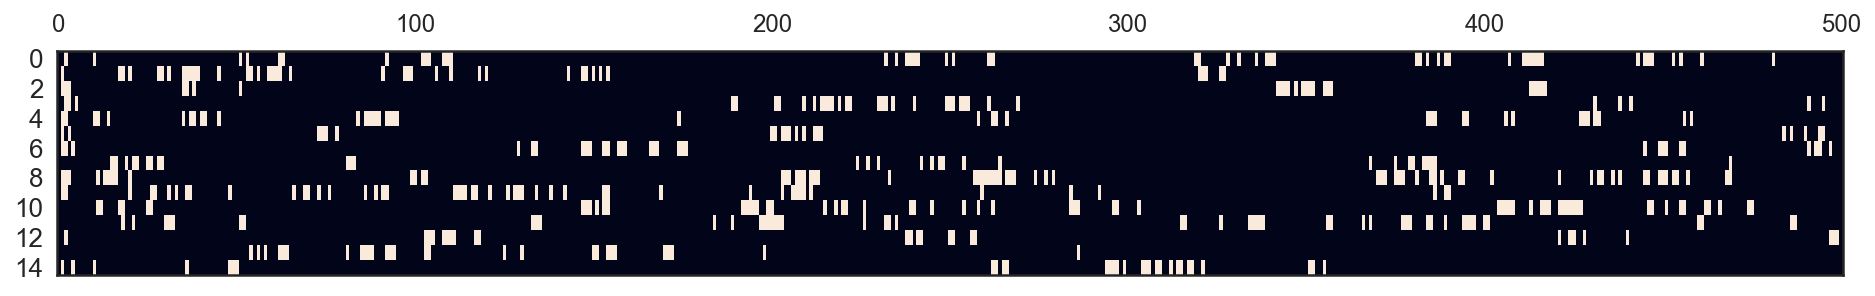

In [317]:
with sns.axes_style('white'):
    plt.matshow(fire_array, aspect='auto')